# QDac and Keysight 34465 sync and buffer

## Benchmarking

In [1]:
%matplotlib notebook
import time
import numpy as np
import matplotlib.pyplot as plt

import qcodes as qc

from qcodes.instrument_drivers.Keysight.Keysight_34465A import Keysight_34465A
from qcodes.instrument_drivers.QDev.QDac import QDac

In [3]:
# Initialise instruments
qdac = QDac('qdac', 'ASRL6::INSTR', update_currents=False)
dmm = Keysight_34465A('dmm', 'TCPIP0::192.168.15.106::inst0::INSTR')

Connected to: Keysight Technologies 34465A (serial:MY54505388, firmware:A.02.14-02.40-02.14-00.49-02-01) in 0.07s


In [12]:
# Prepare DMM
dmm.NPLC(0.02)
dmm.trigger_source('EXT')
dmm.autorange('OFF')  # this guy is important for low times
dmm.range(1)
print('Expected time per point: {} s'.format(dmm.sample_timer_minimum()))

Expected time per point: 0.001047 s


In [25]:
# Prepare QDac
qdac.ch01_sync(1)
qdac.ch01_sync_delay(0.006)
qdac.ch01_sync_duration(0.1)
qdac.ch01_v(0)


We ramp the QDAC from 0 V to 100 mV during the relevant time

### Single shot

In [30]:

Ns = [512, 512, 512, 1024, 1024, 1024, 2048, 2048, 2048, 4096, 4096, 4096]

for N in Ns:
    
    # reset 
    qdac.ch01_v(0)
    time.sleep(1)
    
    # Set number of points
    #N = 2048
    Vrange = 0.1

    # Assign slope accordingly
    slope = Vrange/(N*dmm.sample_timer_minimum())
    qdac.ch01_slope(slope)
    dmm.sample_count(N)

    t_start = time.time()
    dmm.data_buffer.prepare()
    data = qc.Measure(qc.Task(qdac.ch01_v.set, Vrange), dmm.data_buffer).run()
    t_stop = time.time()
    print('Elapsed time: {:.3f} s'.format(t_stop-t_start))
    print('-'*50)

DataSet:
   location = 'data/2017-04-04/#025_{name}_15-32-55'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | dmm_data_buffer | data_buffer  | (512,)
acquired at 2017-04-04 15:32:56
Elapsed time: 0.992 s
--------------------------------------------------
DataSet:
   location = 'data/2017-04-04/#026_{name}_15-32-57'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | dmm_data_buffer | data_buffer  | (512,)
acquired at 2017-04-04 15:32:58
Elapsed time: 0.998 s
--------------------------------------------------
DataSet:
   location = 'data/2017-04-04/#027_{name}_15-32-59'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | dmm_data_buffer | data_buffer  | (512,)
acquired at 2017-04-04 15:33:00
Elapsed time: 1.001 s
--------------------------------------------------
DataSet:
   location = 'data/2017-04-04/#028_{name}_15-33-01'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Measured | dmm_data_buffer |

<IPython.core.display.Javascript object>


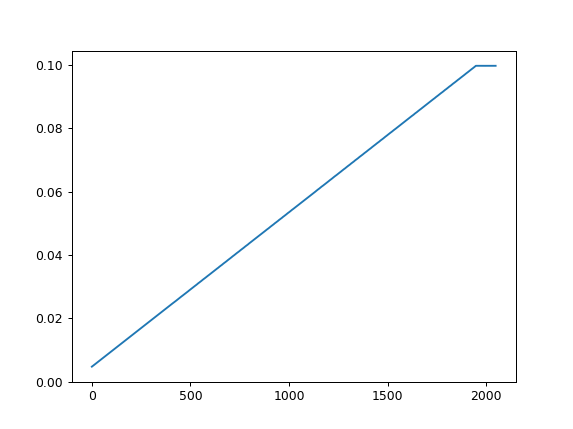

In [28]:
plt.figure()
plt.plot(data.arrays['dmm_data_buffer'])

### 2D stuff

In [8]:
slope = 1
chan_reset_1 = qc.Task(qdac.ch01_slope, 'Inf')
chan_reset_2 = qc.Task(qdac.ch01_v, 0)
chan_reset_3 = qc.Task(qdac.ch01_slope, slope)
chan_go = qc.Task(qdac.ch01_v, 1)

In [9]:
loop = qc.Loop(qdac.ch02_v.sweep(0, 1, num=10), delay=1).each(chan_reset_1,
                                                              chan_reset_2,
                                                              chan_reset_3, chan_go,
                                                              dmm.data_buffer)
data = loop.get_data_set(name='testsweep')
plot = qc.QtPlot()
plot.add(data.dmm_data_buffer)
_ = loop.with_bg_task(plot.update, plot.save).run()

Could not pull data from DMM. Perhaps no trigger?


DataSet:
   location = 'data/2017-04-04/#009_testsweep_15-23-28'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | qdac_ch02_v_set | ch02_v       | (10,)
   Measured | dmm_data_buffer | data_buffer  | (10, 1024)
started at 2017-04-04 15:23:42


VisaIOError: ('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', "writing 'DISPLay:TEXT:CLEar' to <Keysight_34465A: dmm>")

In [10]:
dmm.visa_handle.timeout

5000

In [11]:
dmm.reset()

In [14]:

qdac.ch01_slope(1)

In [12]:
dmm.trigger_slope('POS')

In [ ]:
qdac.ch02_v(0)
qdac.ch02_v(5)
qdac.ch02_v(0)

In [15]:
dmm.trigger_source('EXT')
dmm.init_measurement()


In [30]:
qdac._syncoutputs

[[1, 1]]

In [37]:
qdac.debugmode = True

In [38]:
import logging
import sys
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [13]:
dmm.write('*TRG')

In [9]:
print(qdac._assigned_fgs)
print(qdac._syncoutputs)


{1: 1}
[[1, 1]]


In [7]:
qdac.ch01_slope('Inf')

In [11]:
qdac.ch01_sync(0)

In [6]:
'{:02}'.format(9)

'09'

In [12]:
qdac.ch01_v(0)

In [32]:
dmm.NPLC()

0.02

In [33]:
dmm.sample_timer_minimum()

0.001047

In [36]:
dmm.NPLC()/50

0.0004